In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
from sklearn.model_selection import train_test_split

In [2]:
# test if GPUs are available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set project root, maybe you need to firstly 
# add shortcut of CS 766 Project to drive.
project_root = './drive/MyDrive/CS 766 Project/Project Coding and Data Files'

In [30]:
# class to initialize CNNs
class OriginCNN(object):
  """docstring for OriginCNN"""
  def __init__(self):
    self.optimizer = 'adam'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # will add more properties


  def build(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu', input_shape=(224, 224)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2))

    model.summary()
    model.compile(optimizer=self.optimizer,
                loss=self.loss,
                metrics=['accuracy'])
    self.model = model


  def train(self, train_images, train_labels, test_images, test_labels, epochs):
    self.history = self.model.fit(train_images, train_labels, epochs=epochs, 
        validation_data=(test_images, test_labels))


  def evaluate(self, test_images, test_labels):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.model.evaluate(test_images, test_labels, verbose=2)

    print(test_acc)

# this cnn is for testing
class OriginCNN_cifar(object):
  """docstring for OriginCNN"""
  def __init__(self):
    self.optimizer = 'adam'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # will add more properties

  # this method is for cifar dataset, I used it for testing and debugging
  def build(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))

    model.summary()
    model.compile(optimizer=self.optimizer,
                loss=self.loss,
                metrics=['accuracy'])
    self.model = model


  def train(self, train_images, train_labels, test_images, test_labels, epochs):
    self.history = self.model.fit(train_images, train_labels, epochs=epochs, 
        validation_data=(test_images, test_labels))


  def evaluate(self, test_images, test_labels):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.model.evaluate(test_images, test_labels, verbose=2)

    print(test_acc)

In [24]:
# classes to load data
class Cifar10(object):
  """docstring for OriginCNN"""
  def __init__(self):
    # cifar10 is used for debugging
    (train_images, self.train_labels), (test_images, self.test_labels) = datasets.cifar10.load_data()

    # Normalize pixel values to be between 0 and 1
    self.train_images, self.test_images = train_images / 255.0, test_images / 255.0
    print(type(self.train_images))

class DR_resized(object):
  """docstring for DR_resized"""
  def __init__(self):
    # all_images = np.load("Data Batches/Xtrain_Batch0.npy", allow_pickle=True)
    # all_labels = np.load("Data Batches/Ytrain_Batch0.npy", allow_pickle=True)
    # print(all_images.shape)
    # print(all_labels.shape)
    # self.train_images = np.load("Data Batches/Xtrain_Batch0.npy", allow_pickle=True)
    # self.train_labels = np.load("Data Batches/Ytrain_Batch0.npy")
    # self.test_images = np.load("Data Batches/Xtest_Batch.npy")
    # self.test_labels = np.load("Data Batches/Ytest_Batch.npy")
    # print(type(self.train_images))
    image_list = []
    label_list = []
    image_num = 100
    for i in range(image_num):
        img = np.random.rand(224, 224)
        label = [0, 1] if np.random.random() > 0.5 else [1, 0]
        image_list.append(img)
        label_list.append(label)
    
    all_images = np.array(image_list)
    all_label = np.array(label_list)
    
    self.train_images, self.test_images, self.train_labels, self.test_labels \
    = train_test_split(all_images, all_label, test_size=0.2, random_state=9876)




In [31]:
myModel = OriginCNN()

In [12]:
myModel

In [25]:
myData = DR_resized()

In [32]:
myModel.build()

ValueError: ignored

In [ ]:
myModel.train(myData.train_images, myData.train_labels, myData.test_images, myData.test_labels, 10)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1742 - accuracy: 0.5838 - val_loss: 1.0855 - val_accuracy: 0.6124
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0303 - accuracy: 0.6360 - val_loss: 1.0202 - val_accuracy: 0.6360
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9372 - accuracy: 0.6714 - val_loss: 0.9391 - val_accuracy: 0.6727
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8690 - accuracy: 0.6958 - val_loss: 0.9142 - val_accuracy: 0.6851
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8089 - accuracy: 0.7170 - val_loss: 0.9382 - val_accuracy: 0.6836
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7584 - accuracy: 0.7326 - val_loss: 0.8871 - val_accuracy: 0.6979
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7179 - accuracy: 0.7484 - val_loss: 0.8598 - val_accuracy:

313/313 - 1s - loss: 0.8836 - accuracy: 0.7035
0.703499972820282


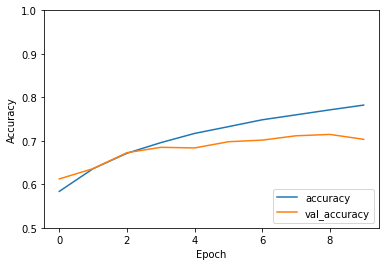

In [ ]:
myModel.evaluate(myData.test_images, myData.test_labels)